In [1]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker as mticker
from sqlalchemy import PickleType

import sys
sys.path.append("../")
from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types


sns.set_theme()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [46]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

df = read_pkl_sql("benchmarks.db", "camel_scan", dtypes=dtypes)
df.columns = df.columns.astype(str)
df = df.assign(lvr=df["variance_ratio"].apply(np.log10),
              lval=df["value"].apply(np.log10))
df = df.assign(d_cat = df["d"].astype(str))

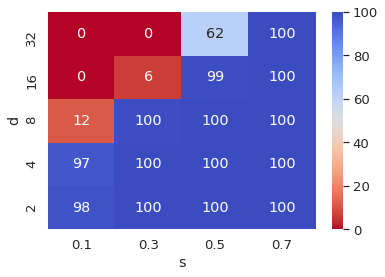

In [47]:
df["valid"] = df["value"] >= 20*df["value_std"]
data = df.groupby(["d","s"])["valid"].agg(lambda x: x.mean()*100).reset_index().pivot("d","s","valid").dropna()
ax = sns.heatmap(data,cmap="coolwarm_r", annot=True, fmt=".0f")
ax.invert_yaxis()
plt.show()

In [48]:
filtered_df = df.loc[df.apply(lambda r: data.loc[r["d"],r["s"]] > 50, axis=1)]
filtered_df = filtered_df.loc[filtered_df["valid"]]

In [49]:
top = filtered_df.groupby(["d","s"]).head(20)

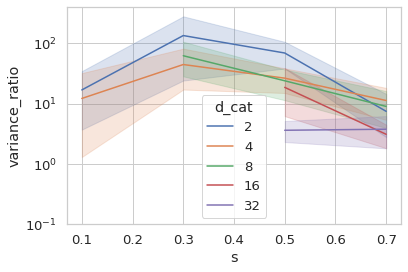

In [63]:
ax = sns.lineplot(data=top, x="s", y="variance_ratio", hue="d_cat")
ax.set(yscale="log",ylim=[0.1,400])
plt.show()

In [55]:
filtered_df.columns

Index(['value', 'target', 'value_std', 'target_std', 'sigma_cutoff',
       'sigmas_off', 'percent_difference', 'variance_ratio', 'match',
       'value_history', 'target_history', 'flat_variance_ratio', 'flow',
       'd_hidden', 'n_bins', 'n_hidden', 'masking', 'repetitions', 'loss',
       'n_points_survey', 'n_iter', 'minibatch_size', 'max_reloads',
       'n_epochs', 'optim_cls', 'betas', 'eps', 'lr', 'checkpoint',
       'checkpoint_on_cuda', 'checkpoint_path', 's', 'norm', 'd', 'git_info',
       'extra_data', 'lvr', 'lval', 'd_cat', 'valid'],
      dtype='object')

In [79]:
hps = ['flow',
       'd_hidden', 'n_bins', 'n_hidden', 'masking',
       'n_points_survey',
       'lr']

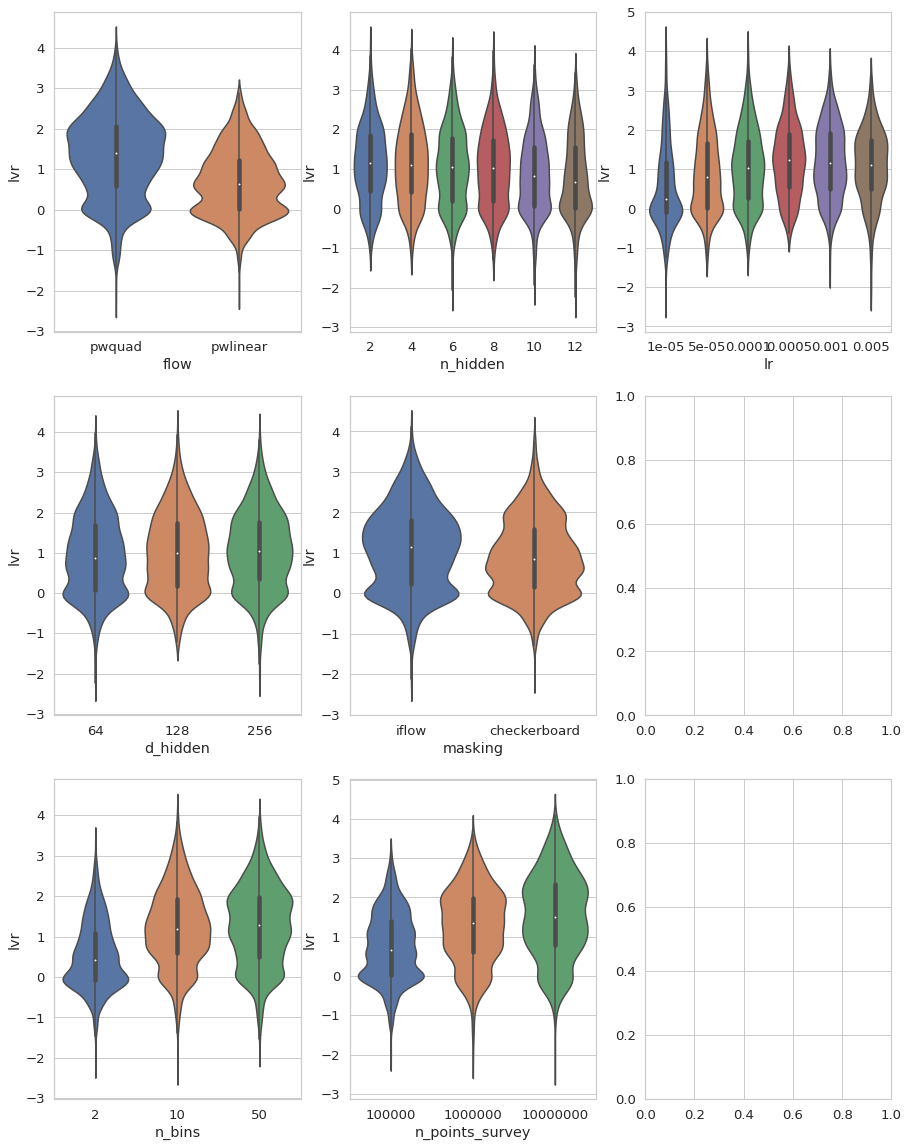

In [80]:
h,v = 3,3 
fig, axs = plt.subplots(h,v)
fig.set_size_inches(15,20)
for i in range(len(hps)):
    sns.violinplot(
        data=filtered_df,
        x=hps[i],
        y="lvr",
        ax=axs[i%h,(i//h)%v],
        scale="width"
    )
plt.show()

In [81]:
df["valid"] = df["value"] >= 20*df["value_std"]
validdata = df.groupby(["d","s"])["valid"].agg(lambda x: x.mean()*100).reset_index().pivot("d","s","valid").dropna()
topdata = filtered_df.groupby(["d","s"])

In [85]:
topdata

In [142]:
res = topdata["variance_ratio"].nlargest(1)
top = res.reset_index().set_index(["d","s"]).join(df[["valid"]],on="level_2").drop("level_2",axis="columns")
top["true_vr"] = (top["variance_ratio"]*top["valid"]).apply(np.log10)
toppivot = top.reset_index().pivot("d","s","true_vr")

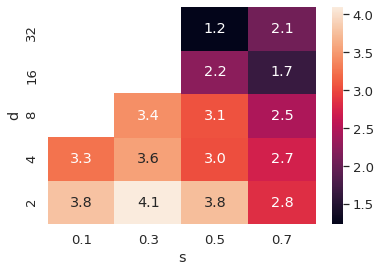

In [148]:
ax = sns.heatmap(toppivot,cmap="rocket", annot=True, fmt=".1f")
ax.invert_yaxis()
plt.show()

<AxesSubplot:xlabel='s', ylabel='true_vr'>

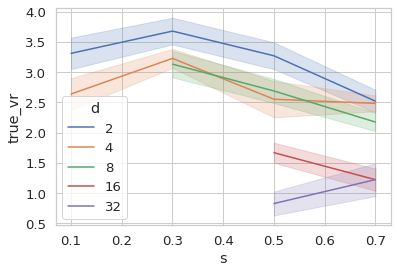

In [162]:
res = topdata["variance_ratio"].nlargest(20)
better = res.reset_index().set_index(["d","s"]).join(df[["valid"]],on="level_2").drop("level_2",axis="columns")
better["true_vr"] = (better["variance_ratio"]*better["valid"]).apply(np.log10)
better = better.reset_index()
sns.lineplot(data=better,x="s",y="true_vr",hue=better["d"].astype(str),ci="sd")